<a href="https://colab.research.google.com/github/dwjang0902/ExampleNew/blob/master/Data_prediction_stock_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# RNN 연습 : 네이버 주식 데이터를 읽어오고,RNN을 활용하여 주가를 예측하는 예제
```

 



요청 URL = http://finance.naver.com/item/sise_day.nhn?code= 066570
종목명 =  LG전자 Code =  066570
URL =  http://finance.naver.com/item/sise_day.nhn?code= 066570
066570
http://finance.naver.com/item/sise_day.nhn?code=066570
 마지막 페이지 :  422


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


 length =  4200
<class 'numpy.ndarray'> (2100, 10, 6)
<class 'numpy.ndarray'> (2100, 10, 1)
입력 디멘젼 :  6
출력 디멘젼 :  1
셀의 수 :  10
히든 사이즈 :  30
다중계층 수 =  3
Epoches =  100
batch_size 32
num_batches 65


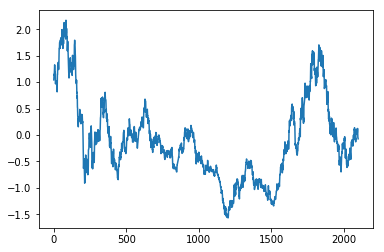

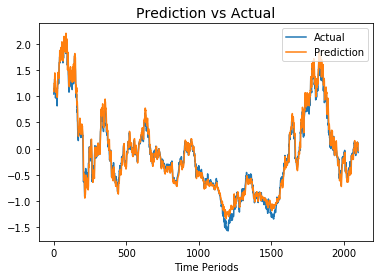

In [30]:
""" ---------------------------------------------------------------------------------------
                주가 데이터를 네이버 사이트에서 읽어와서, 종가를 예측하는 예제
 참조 : https://coolingoff.tistory.com/category/%5B%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%5D/Tensorflow
        https://sshkim.tistory.com/153
        https://www.youtube.com/watch?v=odMGK7pwTqY
        Deep Learning ZerotoAll
        2019. 5. 3
---------------------------------------------------------------------------------------""" 

#----------------------
#주가 데이터 읽어오기
#----------------------
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

#------------------------------------
# 한국거래소에서 종목코드 가져오기
url = 'http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13'
code_df = pd.read_html(url, header=0)[0]

# 종목코드가 6자리이기 때문에 6자리를 맞춰주기 위해 설정해줌 
code_df.종목코드 = code_df.종목코드.map('{:06d}'.format)

# 우리가 필요한 것은 회사명과 종목코드이기 때문에 필요없는 column들은 제외해준다. 
code_df = code_df[['회사명', '종목코드']]

# 한글로된 컬럼명을 영어로 바꿔준다. 
code_df = code_df.rename(columns={'회사명': 'name', '종목코드': 'code'}) 
#print(code_df.head())

#------------------------------------
# 종목 이름을 입력하면 종목에 해당하는 코드를 불러와 
# 네이버 금융(http://finance.naver.com)에 넣어줌 
def get_url(item_name, code_df): 
    code = code_df.query("name=='{}'".format(item_name))['code'].to_string(index=False) 
    url = 'http://finance.naver.com/item/sise_day.nhn?code={code}'.format(code=code) 
    print("요청 URL = {}".format(url)) 
    print('종목명 = ',item_name, 'Code =', code)
    print('URL = ', url)
    return url, code

# 종목명의 일자데이터 url 가져오기 
item_name='LG전자' 
url, code = get_url(item_name, code_df)
#print(type(code))
# 왜 이렇게 해야 동작하는지 잘 모르겠다.
code = np.int(code)
code = str(code)
stockItem = code
code = code.zfill(6) # 자릿수 맞추기
code_num = code

#------------------------------------
# 마지막 페이지 찾기

import urllib
import time
from urllib.request import urlopen
from bs4 import BeautifulSoup
stockItem = code_num
print(stockItem)
url = 'http://finance.naver.com/item/sise_day.nhn?code='+ stockItem
print(url)
html = urlopen(url)  
source = BeautifulSoup(html.read(), "html.parser")
maxPage=source.find_all("table",align="center")
#print(maxPage)
mp = maxPage[0].find_all("td",class_="pgRR")
page = mp[0].a.get('href')
page = page.split('&')
#print("page : ", page[-1]) 
page = page[-1].split('=')
page = page[-1]
print( " 마지막 페이지 : ", page)

#------------------------------------
# 데이터 가져오기

last_page = int(page)
number_page = np.min([80, last_page])

# 일자 데이터를 담을 df라는 DataFrame 정의 
df = pd.DataFrame()

for page in range(1, last_page): 
#    pg_url = '{url}&page={page}'.format(url=url, page=page) # 동작을 않는다, 이유를 모르겠다 ???
    pg_url = 'http://finance.naver.com/item/sise_day.nhn?code=' + code_num + '&page='+ str(page)
#    print(pg_url)
#    df = pd.read_html(pg_url)
    df = df.append(pd.read_html(pg_url, header=0)[0], ignore_index=True)
 
# NaN 데이타 제거
df = df.dropna(axis = 0)

# 한글로 된 컬럼명을 영어로 바꿔줌 
df = df.rename(columns= {'날짜': 'date', '종가': 'close', '전일비': 'diff', '시가': 'open', '고가': 'high', '저가': 'low', '거래량': 'volume'}) 

# 데이터의 타입을 int형으로 바꿔줌 
#df[['close', 'diff', 'open', 'high', 'low', 'volume']]  = df[['close', 'diff', 'open', 'high', 'low', 'volume']].astype(float) 

# 일자(date)를 기준으로 오름차순 정렬 
df = df.sort_values(by=['date'], ascending=True) 

# 상위 5개 데이터 확인
#print( df.tail(5))

#------------------------------------------------------------
# 예측하기 by RNN
#------------------------------------------------------------
#input_data = df.as_matrix()[:, 1:7].astype(int) 
input_data = df.to_numpy()[:, 1:7].astype(int)
#print(type(input_data), input_data.shape)
#print(input_data[0])

# 데이터 스케일링
#-----------------------------
from sklearn.preprocessing import scale, robust_scale, minmax_scale, maxabs_scale
input_data = scale(input_data) 
input_data = np.asarray(input_data)

# RNN 입력데이터 준비
#-------------------------------
def gen_xy_data(input_data, seq_len, pred_step = 1) :
        x_data = []
        y_data = []
        length = input_data.shape[0] - seq_len - pred_step+1
        print(" length = ", length)
        for i in range(length) :
            x = input_data[i:i+seq_len]
            y = input_data[i+pred_step: i+seq_len+pred_step]
            x_data.append(x)
            y_data.append(y)
        return x_data, y_data

seq_len   = 10 # time_step, RNN셀의 수
pred_step = 1  # 몇번 앞을 예측할지를 결정
#x_data = [batch_size, seq_len, input_dim]; y_data = [batch_size, seq_len, output_dim]
x_data, y_data = gen_xy_data(input_data, seq_len, pred_step)
x_data = np.asarray(x_data)
y_data = np.asarray(y_data)

#print(x_data[0:1])
#print(y_data[0:1])

# 데이터 분리(트레이닝, 테스트)
#-------------------------------
def train_test_split_self(x_data, y_data, test_size=0.30, self = 1, random_state = None):
    if self == 0 : 
        x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.50, random_state = random_state)
    else :
        train_size = int(x_data.shape[0]*test_size)
        x_train = x_data[0:train_size]; y_train = y_data[0:train_size]
        x_test = x_data[train_size:]; y_test = y_data[train_size:]
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = train_test_split_self(x_data, y_data, test_size=0.50, random_state= None)
    
y_train = y_train[:,:,0]
y_test = y_test[:,:,0]
y_train = np.expand_dims(y_train, axis = 2)
y_test = np.expand_dims(y_test, axis = 2)

print(type(x_train), x_train.shape)
print(type(y_train), y_train.shape)
#print(y_train[0])
#print(y_test[0])

plt.plot(y_test[:,1])

#-----------------------------------------------------------
# 학습 및 예측; RNN
#-----------------------------------------------------------

tf.reset_default_graph()

#Parameter
#----------------------------
input_dim = x_train.shape[2] #6, 여기서는 [6]
output_dim = 1 # 종가만 예측하는 것으로 한다
seq_len = seq_len
hidden_size = 30
print("입력 디멘젼 : ",input_dim)
print("출력 디멘젼 : ",output_dim)
print("셀의 수 : ",seq_len)
print("히든 사이즈 : ",hidden_size)

#Model
X = tf.placeholder(tf.float32, [None, seq_len, input_dim])
Y = tf.placeholder(tf.float32, [None, seq_len, output_dim])

# 참조 : https://github.com/tensorflow/tensorflow/issues/16186

# 멀티 셀 정의, forward
#----------------------------
def cell():
   c = tf.nn.rnn_cell.BasicLSTMCell(hidden_size, forget_bias=1.0)
   #c = tf.nn.rnn_cell.GRUCell(hidden_size)
   #c = tf.nn.rnn_cell.BasicRNNCell(hidden_size)
   return c

num_mult = 3
print("다중계층 수 = ",num_mult)
cells = tf.contrib.rnn.MultiRNNCell([cell() for _ in range(num_mult)])
outputs, _states = tf.nn.dynamic_rnn(cells, X, dtype = tf.float32)
#outputs = [batch_size, seq_len, hidden_size]

# 변수 정의 및 출력 reshape
softmax_w = tf.Variable(tf.random_normal(shape=[hidden_size, output_dim]), dtype=tf.float32)
softmax_b = tf.Variable(tf.random_normal(shape=[output_dim]), dtype=tf.float32)
output = tf.reshape(outputs, [-1, hidden_size]) #[batch_size*seq_len, hidden_size]

# 최종 출력값을 설정합니다; 일종의 dense_layer 추가 ...
#logits = tf.contrib.layers.fully_connected(output,output_dim)
logits = tf.matmul(output, softmax_w) + softmax_b # logits : [batch_size * seq_length, output_dim]

logits = tf.reshape(logits ,[-1, seq_len, output_dim]) #reshape
#logits = tf.nn.relu(logits)
#logits = tf.math.tanh(logits)
predictions = logits

# Loss, 트레이너 정의 등
#----------------------------
# 디멘젼에 주의 할 것
loss = tf.losses.mean_squared_error(predictions = logits, labels = Y,  weights=1.0)
loss_total = tf.reduce_mean(loss)  

learning_rate = 0.0001

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss_total)

init = tf.global_variables_initializer()

epoches = 100
batch_size = 32
num_batches = int(x_train.shape[0]/batch_size)
print("Epoches = ", epoches)
print("batch_size",batch_size)
print("num_batches", num_batches)

#---------------------------------------------------------------------------------------
with tf.Session() as sess :
    sess.run(init)
    for ep in range(epoches) :
        #sess.run(training_op, feed_dict = { X : x_train, Y: y_train}) #트레이닝
        
        for bh in range(num_batches-1) :
            bh0 = int(bh*batch_size); bh1 = int((bh+1)*batch_size)
            x_batches, y_batches = x_train[bh0:bh1], y_train[bh0:bh1] # 배치 만들기
            sess.run(training_op, feed_dict = { X : x_batches, Y: y_batches}) # 트레이닝
                
        if ep % 100 == 0 :
            mse = loss.eval(feed_dict = { X : x_test, Y: y_test})

    y_pred = sess.run(predictions, feed_dict = {X: x_test}) # 예측
    #    print(" Prediction = \n ", np.squeeze(y_pred))

#결과 그리기    
plt.figure(2)
plt.title("Prediction vs Actual", fontsize = 14)
plt.plot(np.squeeze(y_test)[:,1], label = "Actual") 
plt.plot(np.squeeze(y_pred)[:,1], label ="Prediction") 
plt.legend(loc = "upper right")
plt.xlabel("Time Periods")
plt.show()
